In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
from pathlib import Path

In [2]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

In [3]:
%run SVR_MAPE_Library.ipynb # SVR_general_cvxopt + IterativeRun

In [3]:
data_path = Path().resolve().parent / "Data" / "Data1.xlsx"
y1 =pd.read_excel(data_path).set_index("fecha").loc["2007-01-01":"2019-08-25"]
X1 = pd.read_csv("X.csv")

X = X1.drop(["fecha"], axis = 1).to_numpy(); y = y1.to_numpy()

# X, X_test, y, y_test = train_test_split(X, y, test_size = 100, shuffle = False)

# scaler = MaxAbsScaler(); scaler.fit(X); X = scaler.transform(X)
# X_test = scaler.transform(X_test)

# scaler1 = MaxAbsScaler(); scaler1.fit(y); y = scaler1.transform(y).reshape(-1)

# Run optimization

In [9]:
# Initialize the iterative model. Create folder on pickle folder first
itrrun = IterativeRun(folder = "probe", n = 40, itr = 1)

In [10]:
class newJSONLogger(JSONLogger):

      def __init__(self, path):
            self._path=None
            super(JSONLogger, self).__init__()
            self._path = path if path[-5:] == ".json" else path + ".json"

In [11]:
# Bounded region of parameter space
pbounds = {'C': (0.1, 10), 'epsilon': (0.01, 10), 'gamma': (0.0001, 0.1), 'mu': (0.001, 1), 'lmbda': (0.001, 1)}

# Domain reduction function
# bounds_transformer = SequentialDomainReductionTransformer()

# Bayes optimizer instantiation
optimizer = BayesianOptimization(f=itrrun.bas_optit, 
                                 pbounds=pbounds, 
                                 random_state=1, verbose=2, 
#                                  bounds_transformer=bounds_transformer
                                )

# keep data
log_path = Path().resolve().parent / "Logs" / "log_probe.json"
logger = newJSONLogger(path = log_path)
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [12]:
optimizer.maximize(init_points=0, n_iter=0)

# Optimization utilities

In [ ]:
# optimizer.probe(
#     params={"C": 0.5, "epsilon": 0.01, "gamma": 0.02, "mu": -0.3},
#     lazy=True,
# )

In [117]:
# utility = UtilityFunction(kind="ucb", kappa=2.575, xi=0.0)
# opt_iter = 20
# # run model for lmbda and mu negative values
# for _ in range(opt_iter):
#     nwval = optimizer.suggest(utility)
#     while nwval['lmbda'] + nwval['mu'] <= 0:
#         nwval = optimizer.suggest(utility) 
#     target = bas_optit(**nwval)
#     optimizer.register(params=nwval,target=target)

In [75]:
# def opt_filter(C, epsilon, gamma, mu, lmbda):
#     if mu + lmbda <= 0:
#         mu = abs(mu)
#         lmbda = abs(lmbda)
#     return bas_optit(C, epsilon, gamma, mu, lmbda)

In [76]:
# def bas_opt(C, epsilon, gamma, mu, lmbda):
#     predict = SVR_general_cvxopt(kernel = "rbf", C = C, epsilon = epsilon, mu = mu, lmbda = lmbda, gamma = gamma).fit(X, y).predict(X_test)
#     y_pred = scaler1.inverse_transform(predict.reshape(-1, 1))
    
#     return -np.mean(np.abs((y_pred - y_test)/y_test))*100

# Schenell test

### Model 2 (mu)

In [32]:
hyp = {
    'kernel' : "rbf",
    "C": 4.228517846555483, 
       "epsilon": 7.20604168948716, 
       "gamma": 0.0010113231069171437, 
       "mu": 0.7423118951773942
}
cvs = SVR_general_cvxopt(**hyp).fit(X, y)

In [33]:
pre = cvs.predict(X_test)

In [34]:
pre = scaler1.inverse_transform(pre.reshape(-1, 1))

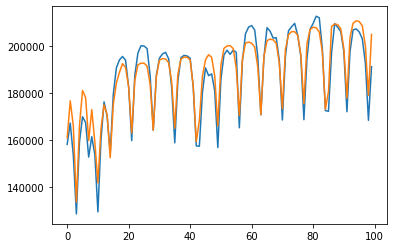

In [35]:
plt.plot(y_test)
plt.plot(pre)

In [38]:
np.mean(np.abs((y_test - pre)/y_test))*100

2.429385277385241

### Model 1 (lmbda_mu)

In [85]:
hyp = {
    'kernel' : "rbf",
    "C": 4.228517846555483, 
    "epsilon": 7.20604168948716, 
    "gamma": 0.0010113231069171437, 
    "lmbda": 1.5186395374328805, 
    "mu": 0.7423118951773942}
cvs2 = SVR_general_cvxopt(**hyp).fit(X, y)

In [86]:
pre2 = cvs2.predict(X_test)

In [87]:
pre2 = scaler1.inverse_transform(pre2.reshape(-1, 1))

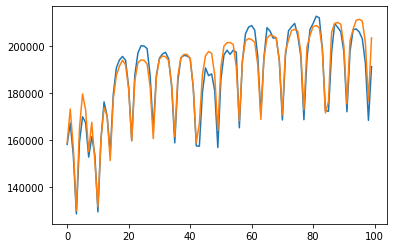

In [88]:
plt.plot(y_test)
plt.plot(pre2)

In [89]:
np.mean(np.abs((y_test - pre2)/y_test))*100

1.8416601559050254

# Econn

In [76]:
from sklearn.metrics.pairwise import pairwise_kernels, linear_kernel, rbf_kernel

In [27]:
class Coca():
    def __init__(self, kernel = "linear", **rest):
        self.kernel = kernel
        self.rest = rest
        
    def create_kernel(self, X):
        kernel = self.kernel
        rest = self.rest
        
        def create(X, kernel):
            if kernel == "linear":
                K = pairwise_kernels(X, X, metric = "linear")
            else:
                K = pairwise_kernels(X, X, metric = kernel, **rest)
                
            return K
        
        def run():
            
            one = create(X, "linear")
            
            other = (kernel, rest.values())
            two = create(X, kernel)
            
            self.one = one; self.two = two
            return self
        
        return run()
        
    def ocation(self):
        return self.one, self.two

In [36]:
un, dos = Coca(kernel = "linear", gamma = 0.01).create_kernel(X).ocation()